<a href="https://colab.research.google.com/github/solarslurpi/GrowBuddy/blob/main/notebooks/PAR_Buddy_mlr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Multiple Linear Regression to Calibrate PAR Buddy

##### Copyright 2022 Margaret Johnson.
__Please send feedback to happyday.github@gmail.com__

MIT License

Copyright (c) 2022 Margaret Johnson

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Hello and Welcome!

[More detail on the PAR Buddy Project](https://github.com/solarslurpi/GrowBuddy/blob/main/pages/PAR_Buddy.md)

I'm exploring using an as7341 as a PAR meter.  Based on what I read in the article, [_A Novel Approach to Obtain PAR with a Multi-Channel Spectral Microsensor, Suitable for Sensor Node Integration_](https://pubmed.ncbi.nlm.nih.gov/34068029/), I thought I'd try using multiple linear regression.

An Apogee mq-500 PAR meter was used as the "ground truth" (dependent variable) for PPFD readings.  The relationship was then determined using the readings from the 8 visible channels of the AS7341 as the independent variables.


# The Challenge

Use [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) to figure out the coefficients for each of the color bands.:

$$ PAR = b_0 + \sum_{i=1}^{n=8} (b_ix_i) + \epsilon $$

Two LED light systems were used:
-     - [MAXSISUN PB1000 Pro Grow Light](https://amzn.to/3uKqPy5) (the "white" LEDs)
    - [Advanced Platinum Series P300 300w](https://amzn.to/3sBnTRR) (the "burple" LEDs)

[Details on sampling](https://github.com/solarslurpi/GrowBuddy/blob/main/pages/PAR_Buddy.md#taking-samples)


# IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA
There were multiple sampling runs.  Each run was saved within a file and stored in the [Growbuddy github repo](https://github.com/solarslurpi/GrowBuddy/tree/main/data).

There are three LED settings:
- ["white" LEDs](https://amzn.to/3uKqPy5) - these have more of a full spectrum visible light.
- ["burple" LEDs](https://amzn.to/3sBnTRR) - the blue/red mix that has lost favor.
- "burple red" LEDs - the lights I have have two settings, veg and bloom.  The bloom has noticeably more red lights.



In [3]:
# Load readings from "white" LEDs
url = 'https://raw.githubusercontent.com/solarslurpi/GrowBuddy/main/data/as7341_white_02052022.csv'
readings_white1 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/solarslurpi/GrowBuddy/main/data/white_02092022.csv'
readings_white2 = pd.read_csv(url)
readings_white = pd.concat([readings_white1,readings_white2],sort=False,ignore_index=True)
readings_white.head()


,PPFD,415,445,480,515,555,590,630,680
0,40,60,282,274,438,659,859,953,465
1,59,86,404,387,624,939,1219,1357,663
2,88,127,599,563,919,1384,1791,1998,977
3,117,170,803,743,1225,1847,2383,2662,1304
4,144,209,984,902,1495,2254,2901,3240,1591


In [4]:
# Load readings from "burple" veg mode LEDs
url = 'https://raw.githubusercontent.com/solarslurpi/GrowBuddy/main/data/burple_02072022.csv'
readings_burple1 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/solarslurpi/GrowBuddy/main/data/burple_02112022.csv'
readings_burple2 = pd.read_csv(url)
readings_burple = pd.concat([readings_burple1,readings_burple2],sort=False,ignore_index=True)
readings_burple.head()

,PPFD,415,445,480,515,555,590,630,680
0,230,699,2150,1101,428,369,797,3418,3049
1,211,651,1795,1058,491,408,935,3759,3368
2,190,496,1496,902,400,349,797,3468,3116
3,182,369,1281,718,301,266,584,2664,2343
4,145,323,1039,606,265,235,508,2374,2175


In [5]:
# Load readings from "burple_red" flower mode LEDs
url = 'https://raw.githubusercontent.com/solarslurpi/GrowBuddy/main/data/burple_red_02132022.csv'
readings_burple_red = pd.read_csv(url)
readings_burple_red.head()

,PPFD,415,445,480,515,555,590,630,680
0,1053,1168,1126,1125,1123,1360,5668,40679,27271
1,976,1049,1007,1006,1005,1215,5034,36034,24629
2,1052,1002,963,951,953,1152,4562,33352,23542
3,1101,1155,1105,1106,1097,1347,5456,39162,27073
4,1103,1020,989,993,973,1204,4981,35239,23940


In [15]:
readings = pd.concat([readings_burple,readings_burple_red,readings_white],sort=False,ignore_index=True)
readings.head()

,PPFD,415,445,480,515,555,590,630,680
0,230,699,2150,1101,428,369,797,3418,3049
1,211,651,1795,1058,491,408,935,3759,3368
2,190,496,1496,902,400,349,797,3468,3116
3,182,369,1281,718,301,266,584,2664,2343
4,145,323,1039,606,265,235,508,2374,2175


# Visualize Data

In [6]:
readings_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PPFD    30 non-null     int64
 1   415     30 non-null     int64
 2   445     30 non-null     int64
 3   480     30 non-null     int64
 4   515     30 non-null     int64
 5   555     30 non-null     int64
 6   590     30 non-null     int64
 7   630     30 non-null     int64
 8   680     30 non-null     int64
dtypes: int64(9)
memory usage: 2.2 KB


In [8]:
readings_burple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PPFD    43 non-null     int64
 1   415     43 non-null     int64
 2   445     43 non-null     int64
 3   480     43 non-null     int64
 4   515     43 non-null     int64
 5   555     43 non-null     int64
 6   590     43 non-null     int64
 7   630     43 non-null     int64
 8   680     43 non-null     int64
dtypes: int64(9)
memory usage: 3.1 KB


In [10]:
readings_burple_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PPFD    56 non-null     int64
 1   415     56 non-null     int64
 2   445     56 non-null     int64
 3   480     56 non-null     int64
 4   515     56 non-null     int64
 5   555     56 non-null     int64
 6   590     56 non-null     int64
 7   630     56 non-null     int64
 8   680     56 non-null     int64
dtypes: int64(9)
memory usage: 4.1 KB


In [16]:
readings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PPFD    129 non-null    int64
 1   415     129 non-null    int64
 2   445     129 non-null    int64
 3   480     129 non-null    int64
 4   515     129 non-null    int64
 5   555     129 non-null    int64
 6   590     129 non-null    int64
 7   630     129 non-null    int64
 8   680     129 non-null    int64
dtypes: int64(9)
memory usage: 9.2 KB


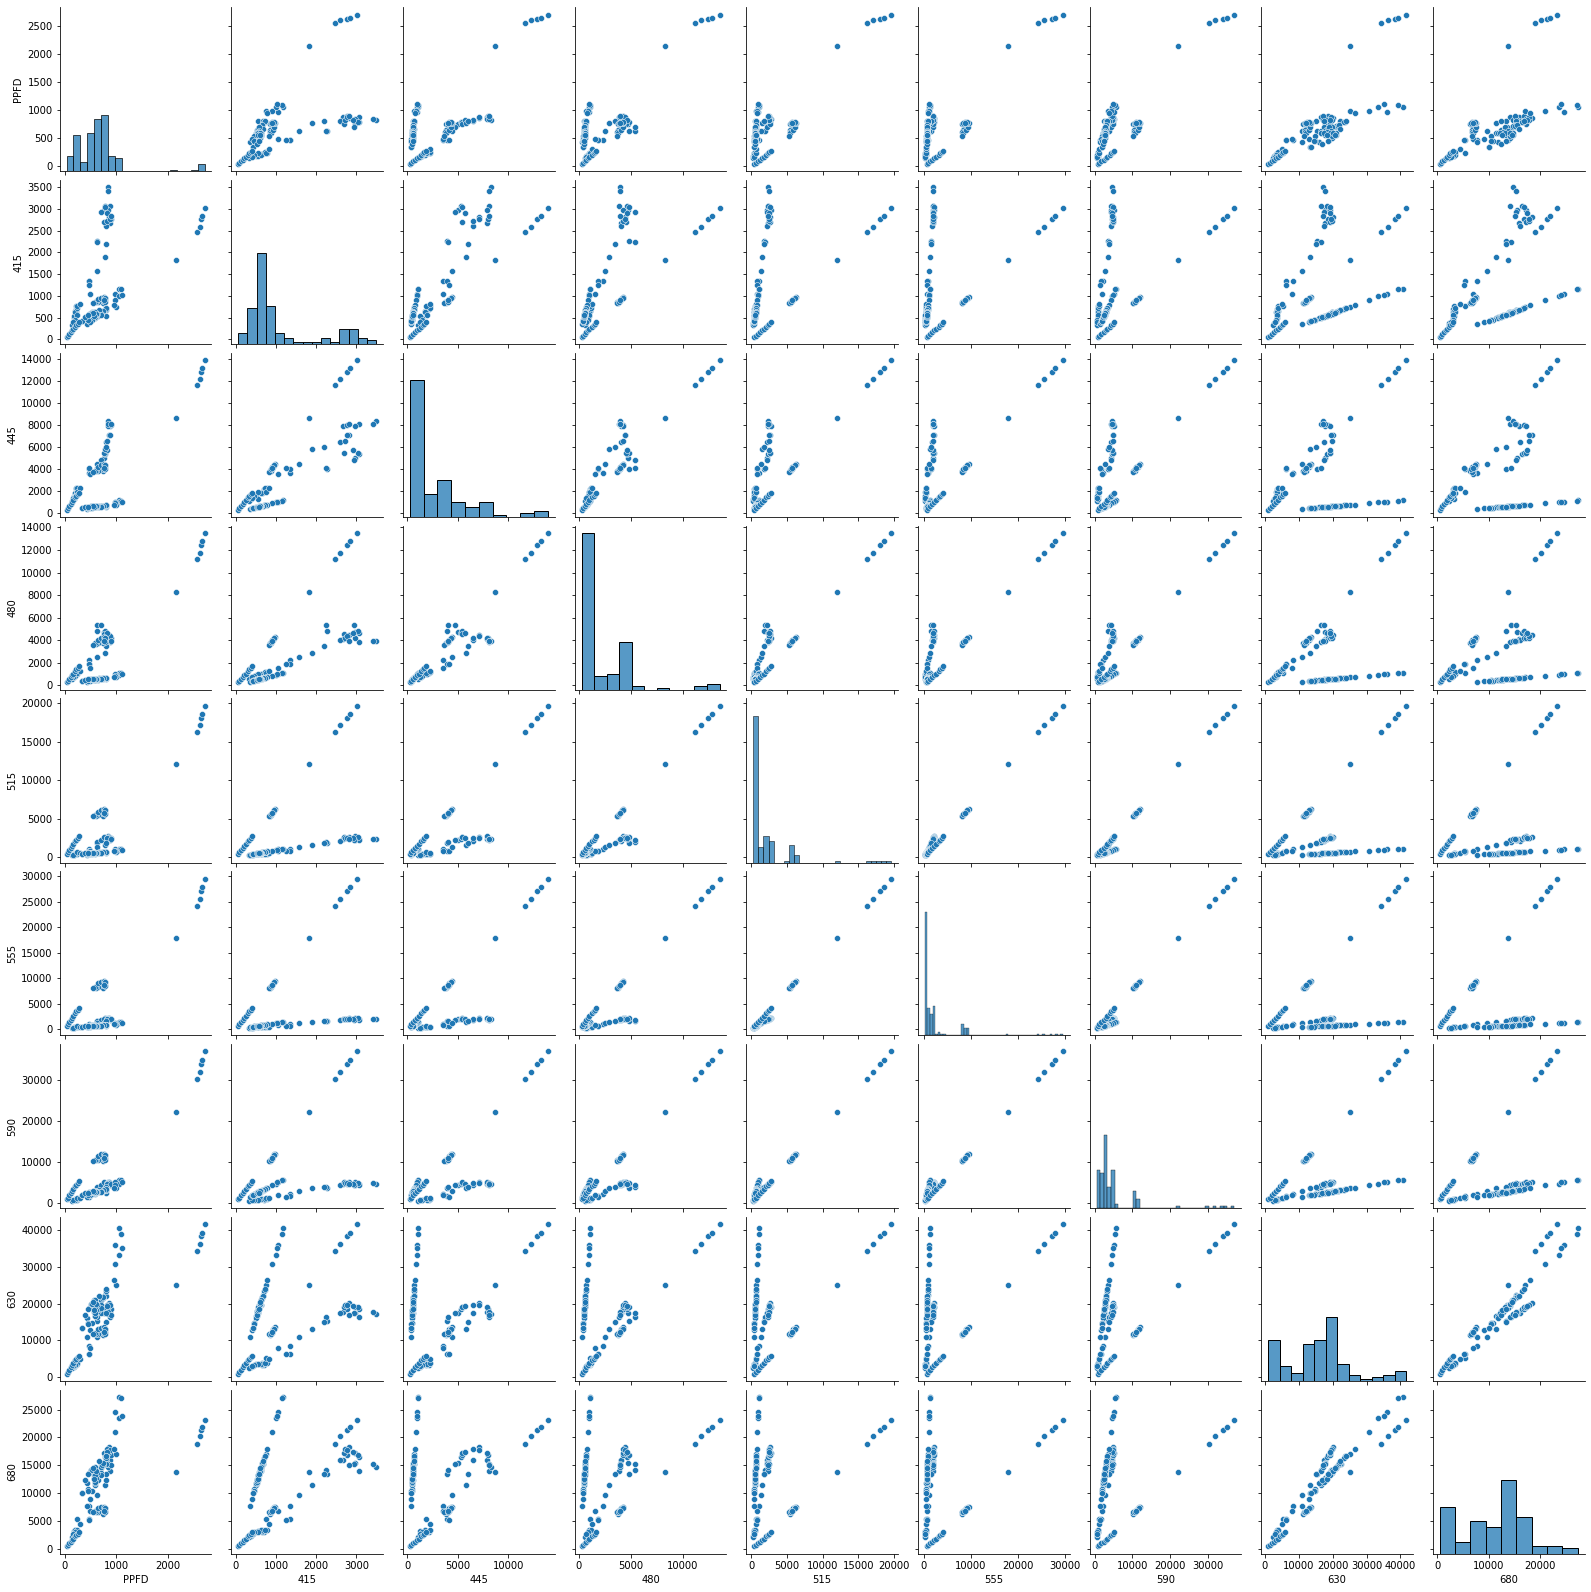

In [17]:
import seaborn as sns
sns.pairplot(readings)

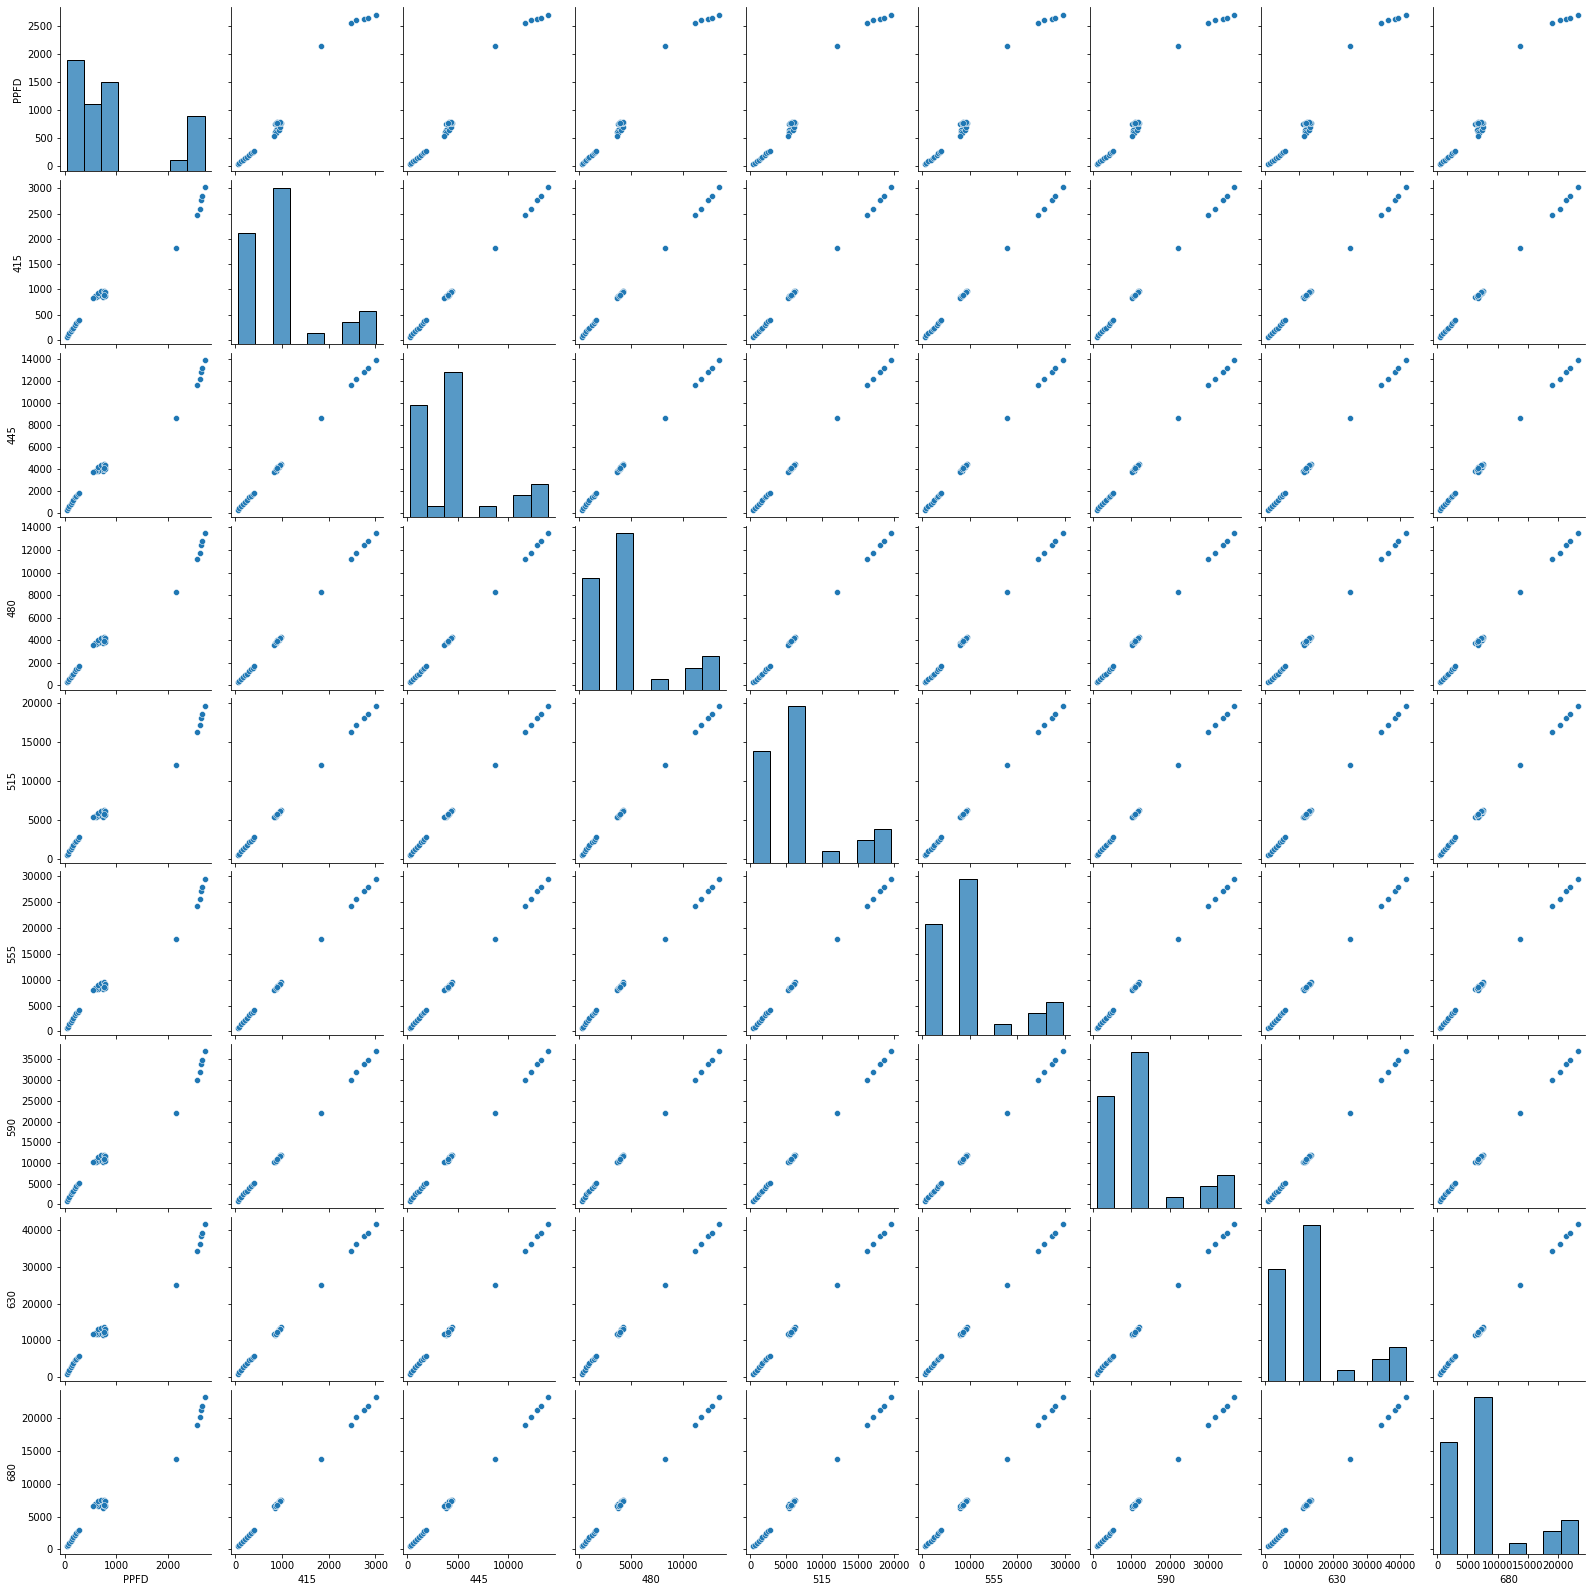

In [11]:
sns.pairplot(readings_white)

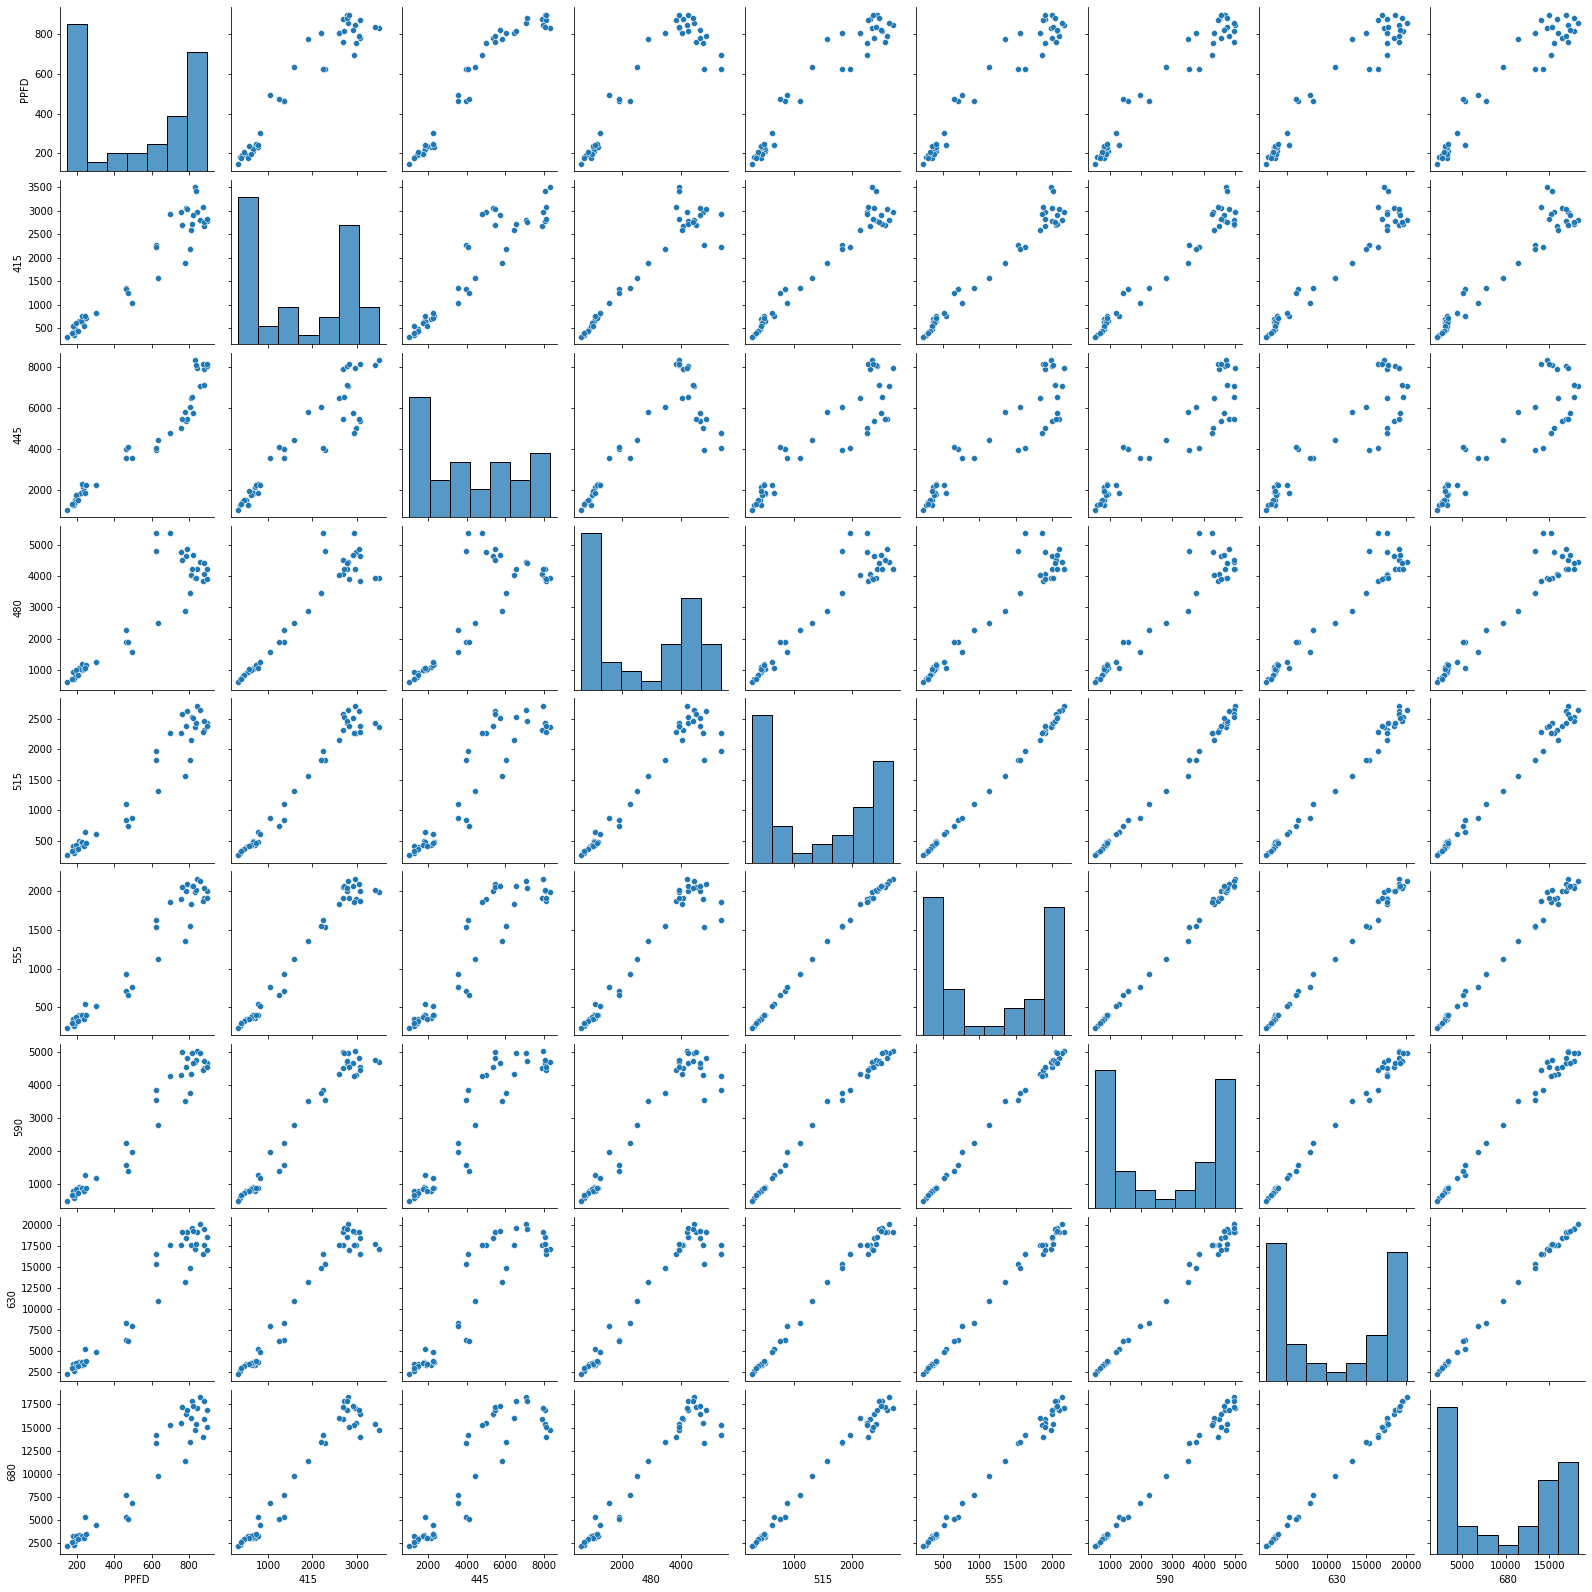

In [12]:
sns.pairplot(readings_burple)

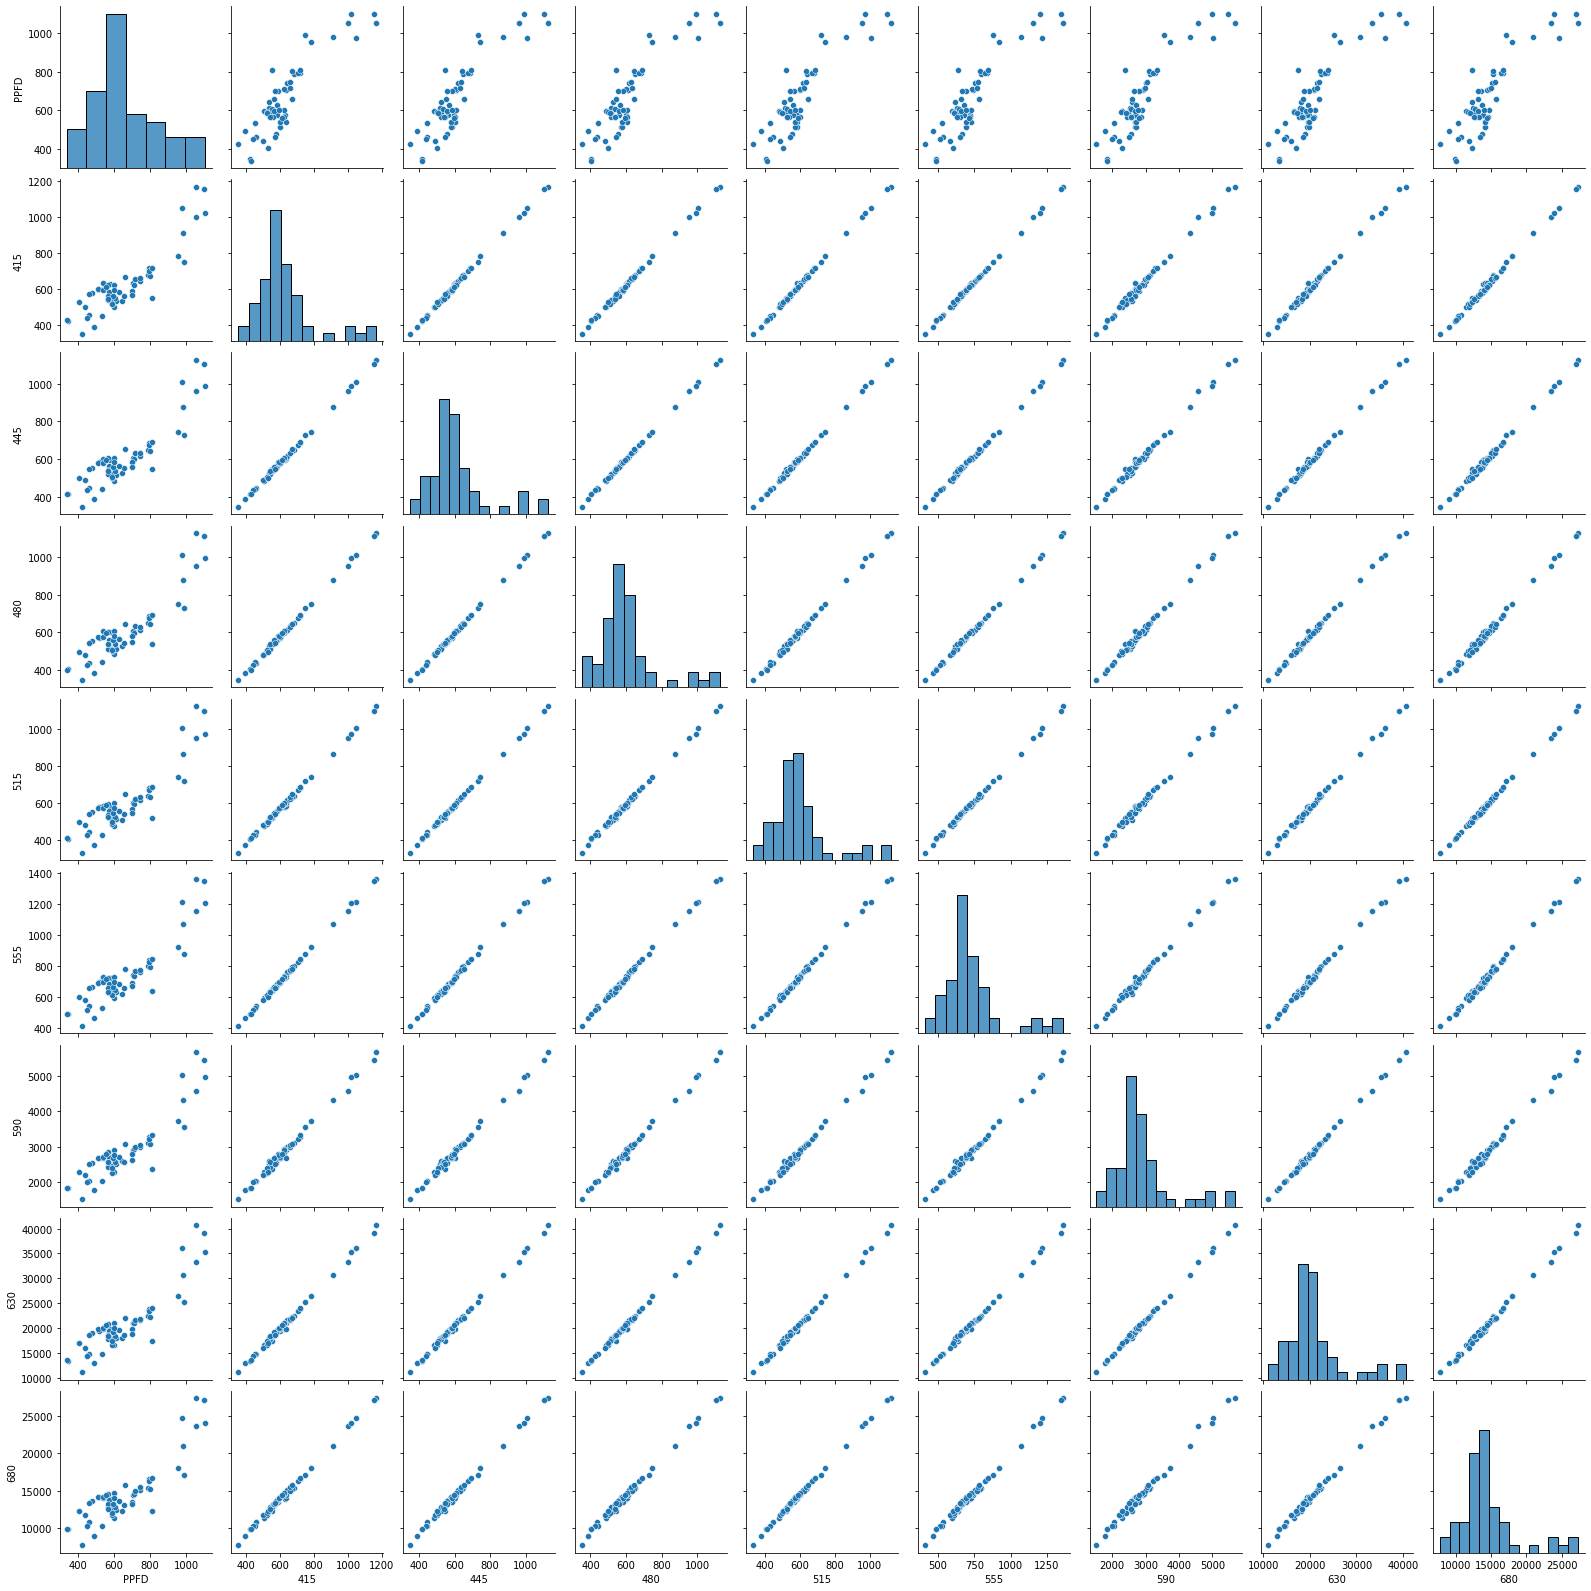

In [13]:
sns.pairplot(readings_burple_red)

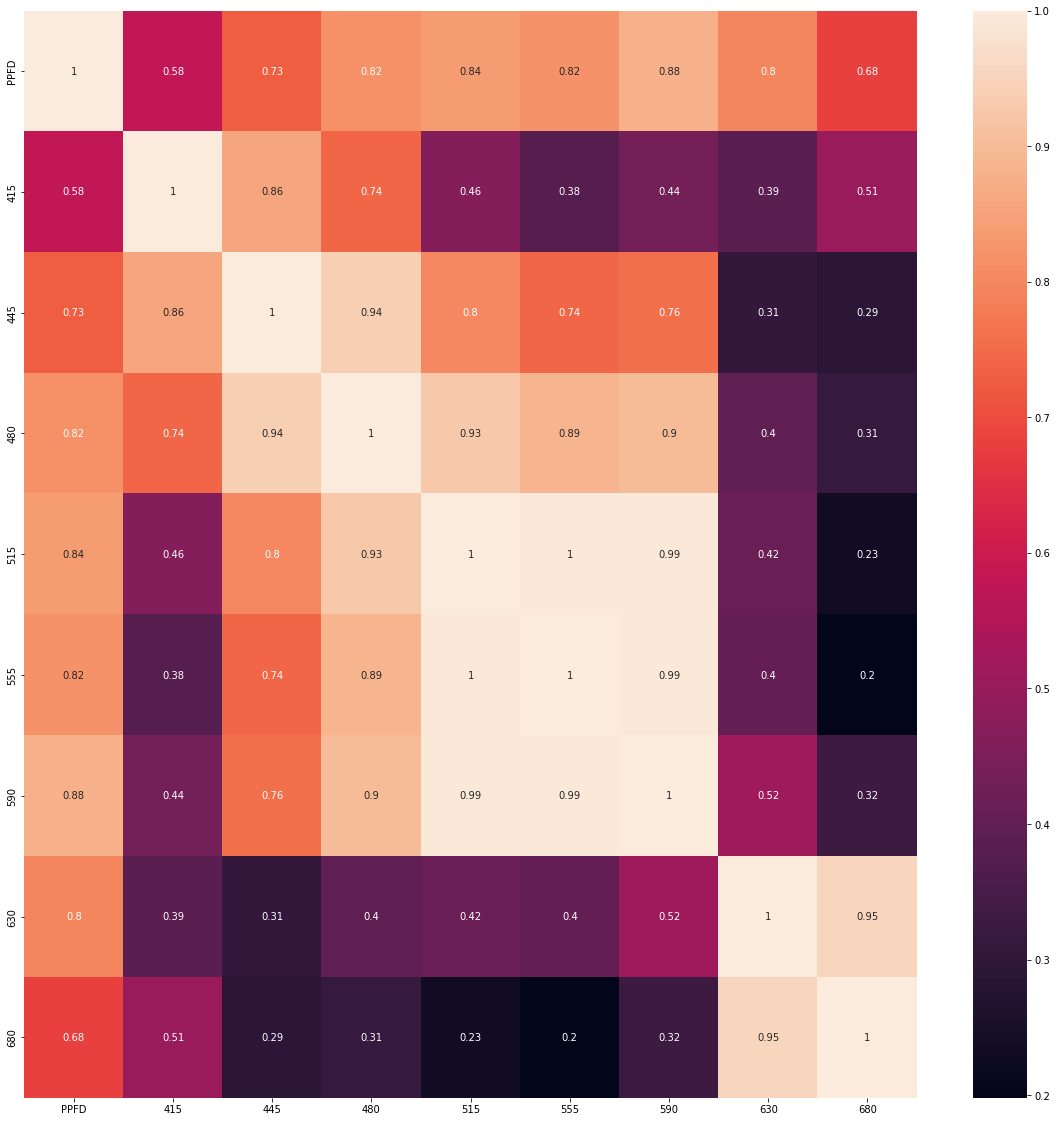

In [19]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(readings.corr(),annot=True)

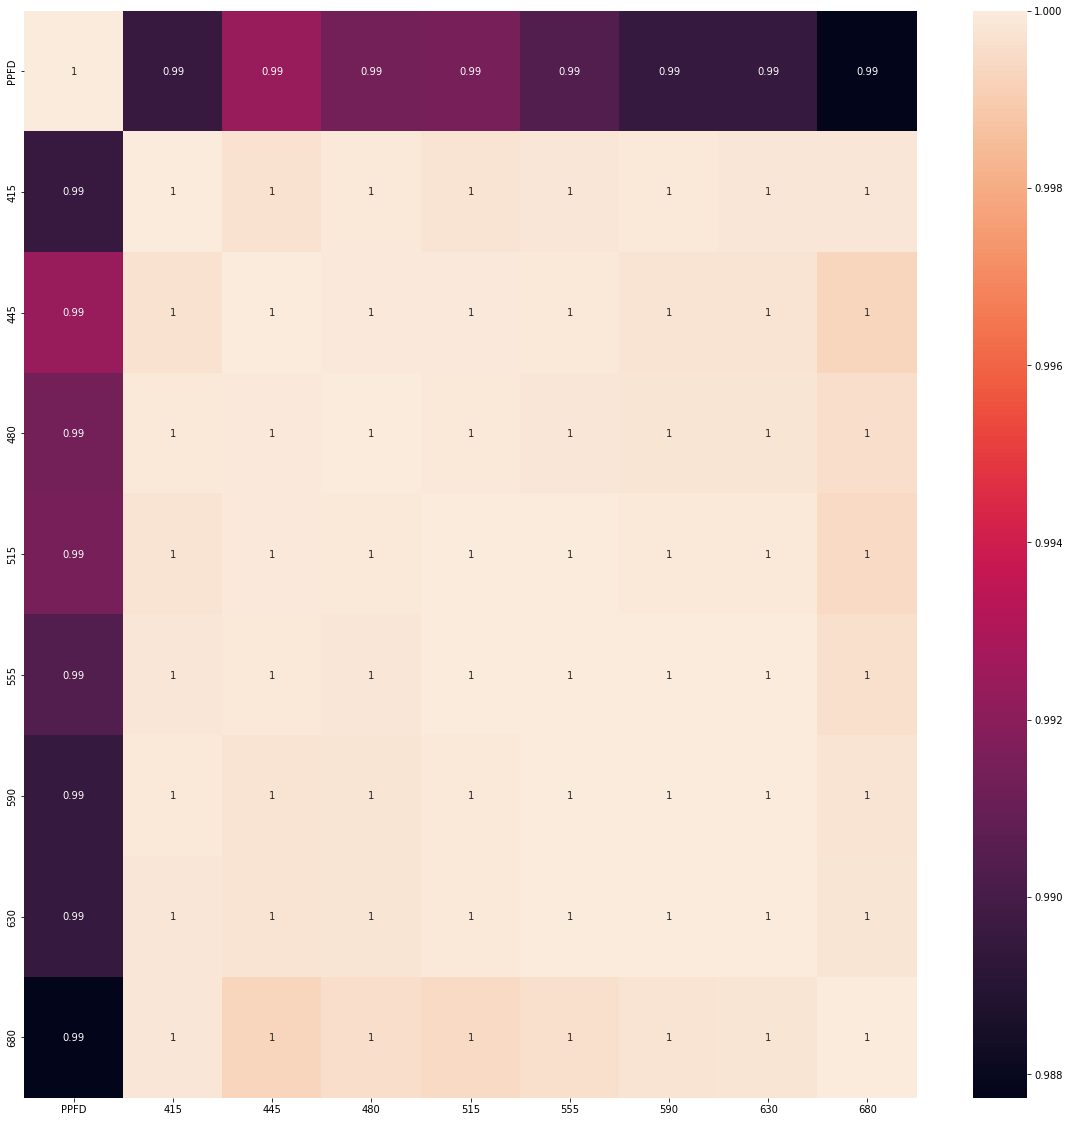

In [20]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(readings_white.corr(),annot=True)

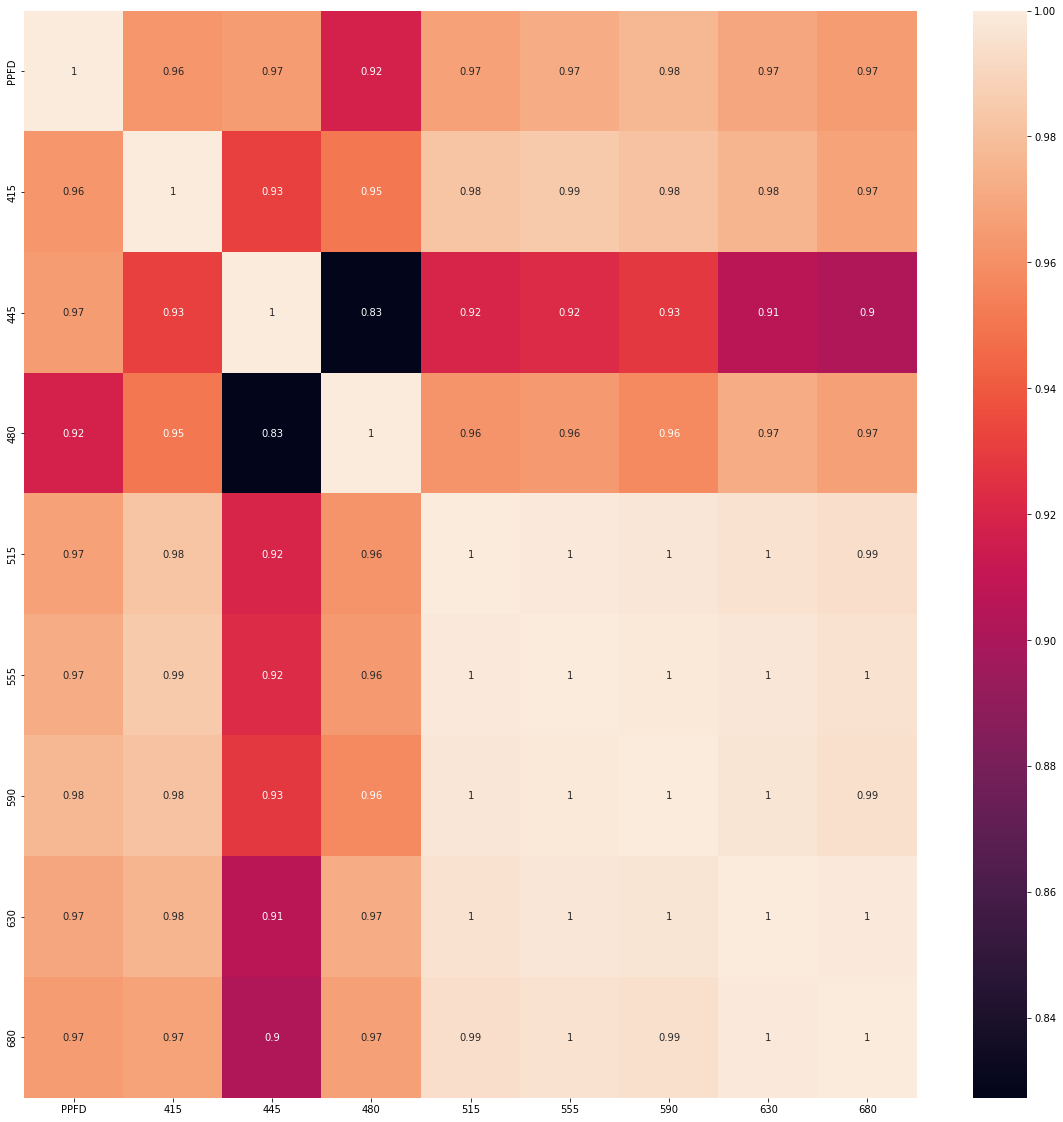

In [21]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(readings_burple.corr(),annot=True)

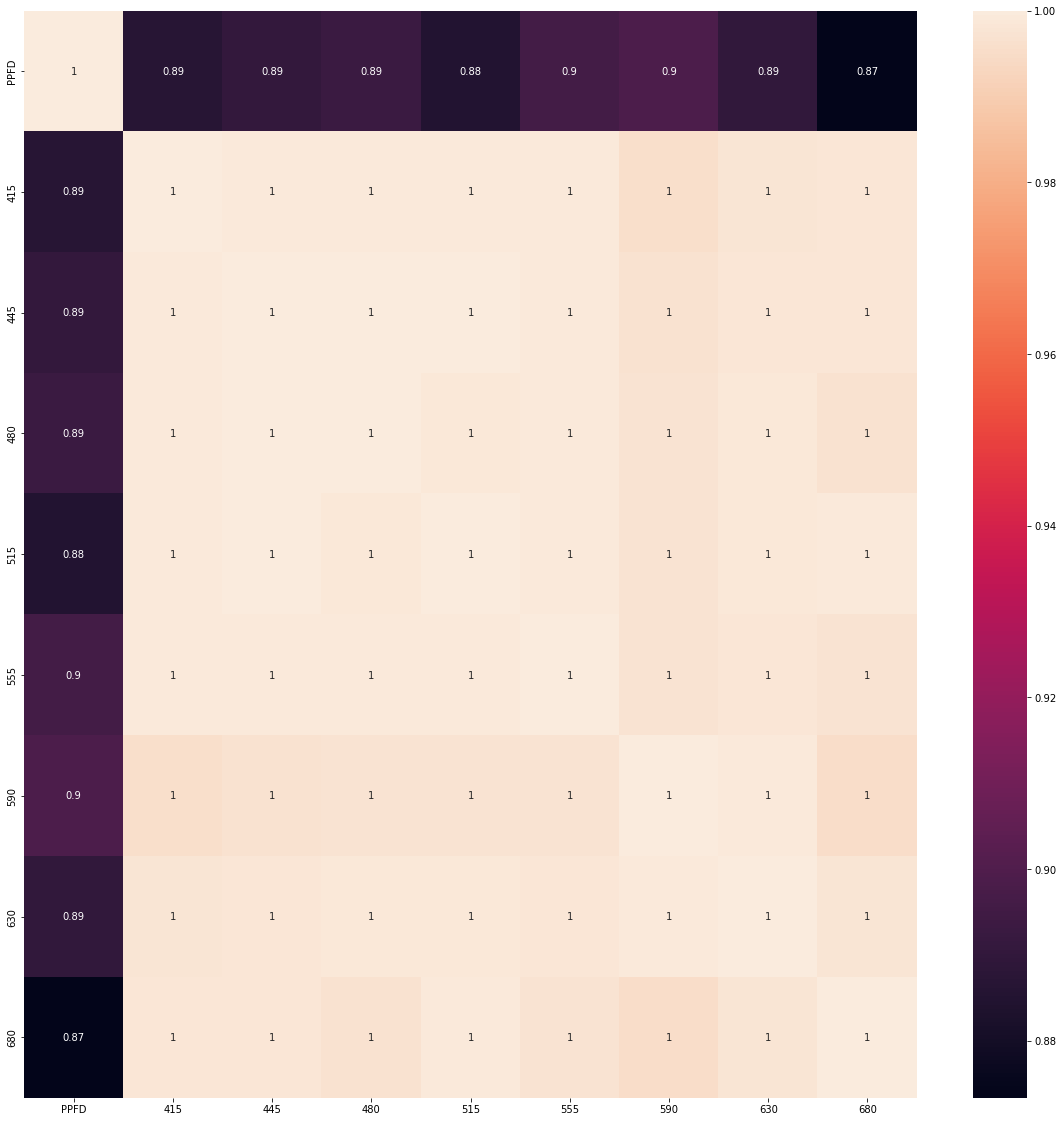

In [22]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(readings_burple_red.corr(),annot=True)

# CREATE TESTING AND TRAINING DATASET (80% Train / 20% Test)

In [93]:
y = readings['PPFD']
y.head()

0    230
1    211
2    190
3    182
4    145
Name: PPFD, dtype: int64

In [94]:
x = readings.iloc[:,1:]
x.head()

,415,445,480,515,555,590,630,680
0,699,2150,1101,428,369,797,3418,3049
1,651,1795,1058,491,408,935,3759,3368
2,496,1496,902,400,349,797,3468,3116
3,369,1281,718,301,266,584,2664,2343
4,323,1039,606,265,235,508,2374,2175


In [95]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [96]:
print(f"There are {len(x_train)} samples in the training set and {len(x_test)} samples in the test set.")

There are 103 samples in the training set and 26 samples in the test set.


# TRAIN MODEL

In [97]:
from sklearn.linear_model import LinearRegression

In [98]:
model=LinearRegression(fit_intercept=True)

In [99]:
model.fit(x_train,y_train)

LinearRegression()

In [100]:
print('linear model coefficients (m)',model.coef_)
print('linear model coefficients (b)',model.intercept_)

linear model coefficients (m) [-0.15875008  0.11842108  0.04081528  0.35649665  0.26407183 -0.47334948
  0.13628613 -0.08327952]
linear model coefficients (b) -10.817578229126866


# EVALUATE MODEL

In [101]:
y_predict = model.predict(x_test)
print(y_predict)
print(y_test)

[ 812.6138502   696.58559903 1100.84049576  753.36680341  699.95143973
  663.9442791   670.14865092  171.77606793  672.26585525  775.11975356
  339.15394974  193.94853169  685.92629726 1228.62080485  802.01711748
 1853.20791968  173.40826595  928.4199318   840.04304515  750.89678362
  978.40039438  195.05719489  461.45714397   99.19689449  632.57098813
  629.36432453]
37      822
111     646
47     1103
110     742
42      805
72      658
33      761
16      243
59      742
122     764
108     275
12      191
63      716
46     1101
119     789
125    2148
103     144
38      898
51      956
31      791
26      900
2       190
69      440
101      88
95      599
53      575
Name: PPFD, dtype: int64


Text(0.5, 1.0, 'PPFD Predictions')

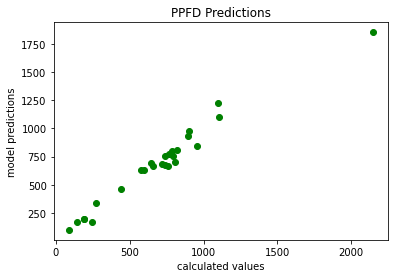

In [102]:
plt.scatter(y_test,y_predict,color='g')
plt.ylabel('model predictions')
plt.xlabel('calculated values')
plt.title('PPFD Predictions')

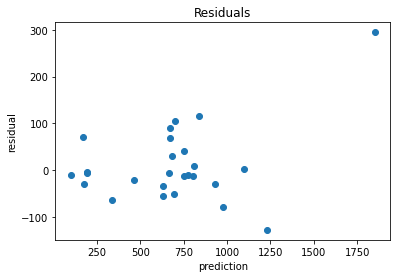

In [104]:
residuals = y_test-y_predict
plt.title('Residuals')
plt.ylabel('residual')
plt.xlabel('prediction')
plt.scatter(y_predict,residuals)

plt.show()

In [105]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt
# r2 is the percentage of dependent variable variation that the (linear) model explains. 0% means there is
# no relationship. 100% means a perfect relationship.
r2 = r2_score(y_test,y_predict)
# Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). 
# It tells you how concentrated the data is around the line of best fit.
# RMSE units is the same as PPFD units, so they are easy to interpret.
RMSE = float(format(np.sqrt(mean_squared_error(y_test,y_predict)),'.3F'))


k = x_test.shape[1]
n = len(x_test)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
MAPE = np.mean(np.abs((y_test-y_predict)/y_test) ) * 1000
print('RMSE = ',RMSE,'\nMSE = ',MSE,'\nMAE = ',MAE,'\nr2 = ',r2,'\nadj_r2 = ',adj_r2,'\nMAPE = ',MAPE)

RMSE =  80.44 
MSE =  1965.6374635831742 
MAE =  37.64862127473029 
r2 =  0.9609505358847771 
adj_r2 =  0.9425743174776133 
MAPE =  83.78263058232987


# VISUALIZE THE RESULTS

In [106]:
from mpl_toolkits.mplot3d import Axes3D

In [138]:
# Create a mesh grid divided into a 100 x 100 surface
x_surf,y_surf = np.meshgrid(np.linspace(readings['415'].min(),readings['415'].max(),100),np.linspace(readings['680'].min(),readings['680'].max(),100))
x_surf.shape

(100, 100)

In [124]:
# We can only plot two independent variables...so we'll predict with these two.
onlyX = pd.DataFrame({'415':x_surf.ravel(),'680':y_surf.ravel()})
onlyX.head()

,415,680
0,60.000000,465.0
1,94.707071,465.0
2,129.414141,465.0
3,164.121212,465.0
4,198.828283,465.0


In [128]:
x_train

,415,445,480,515,555,590,630,680
99,60,282,274,438,659,859,953,465
105,296,1390,1250,2094,3161,4057,4534,2238
106,332,1537,1422,2282,3468,4413,4939,2504
34,2722,6537,4241,2530,2065,4957,19666,17870
113,865,3832,3758,5485,8343,10561,12036,6847
...,...,...,...,...,...,...,...,...
112,851,3762,3696,5390,8167,10332,11753,6683
49,550,547,541,522,639,2389,17454,12286
96,543,538,539,524,632,2570,18347,12629
52,679,649,651,640,797,3119,22341,15322


In [131]:
readings.head()

,PPFD,415,445,480,515,555,590,630,680
0,230,699,2150,1101,428,369,797,3418,3049
1,211,651,1795,1058,491,408,935,3759,3368
2,190,496,1496,902,400,349,797,3468,3116
3,182,369,1281,718,301,266,584,2664,2343
4,145,323,1039,606,265,235,508,2374,2175


In [139]:
x_fit_input = readings[['415','680']]
y_fit_input = readings['PPFD']
model.fit(x_fit_input,y_fit_input)
predictY = model.predict(onlyX)
predictY.shape

(10000,)

In [148]:
predictY = predictY.reshape(x_surf.shape)
predictY.shape

(100, 100)

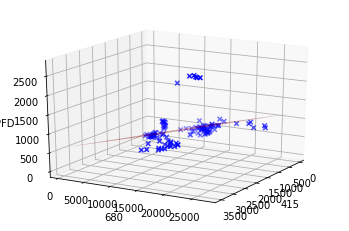

In [150]:
plt.style.use('default')

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter( readings['415'], readings['680'] , readings['PPFD'] , c = 'blue', marker ='x'  )
ax.plot_surface(x_surf, y_surf, predictY, color = 'red', alpha = 0.3)
ax.set_xlabel('415')
ax.set_ylabel('680')
ax.set_zlabel('PPFD')
ax.view_init(20,30)

In [ ]:
X = x.values.reshape(-1,2)
Y = readings['PPFD']

In [ ]:
X

array([[ 699, 2150],
       [1101,  428],
       [ 369,  797],
       [3418, 3049],
       [ 651, 1795],
       [1058,  491],
       [ 408,  935],
       [3759, 3368],
       [ 496, 1496],
       [ 902,  400],
       [ 349,  797],
       [3468, 3116],
       [ 369, 1281],
       [ 718,  301],
       [ 266,  584],
       [2664, 2343],
       [ 323, 1039],
       [ 606,  265],
       [ 235,  508],
       [2374, 2175],
       [ 641, 1886],
       [1013,  430],
       [ 369,  822],
       [3388, 3024],
       [ 649, 1833],
       [1043,  484],
       [ 397,  881],
       [3571, 3208],
       [ 545, 1258],
       [ 946,  414],
       [ 354,  811],
       [3540, 3239],
       [ 765, 2294],
       [1179,  473],
       [ 406,  907],
       [3740, 3308],
       [ 624, 1758],
       [ 994,  437],
       [ 382,  869],
       [3631, 3322],
       [ 558, 1932],
       [1024,  414],
       [ 354,  799],
       [3529, 3059],
       [ 718, 2248],
       [1168,  470],
       [ 404,  898],
       [3895,

In [ ]:
from sklearn import linear_model

In [ ]:
x = X[:,0]
y = X[:,1]
z = Y

x_pred = np.linspace(x.min(),x.max(),30)
y_pred = np.linspace(y.min(),y.max(),30)
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

ols = linear_model.LinearRegression()
model = ols.fit(X,Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)
r2

ValueError: ignored

ValueError: ignored

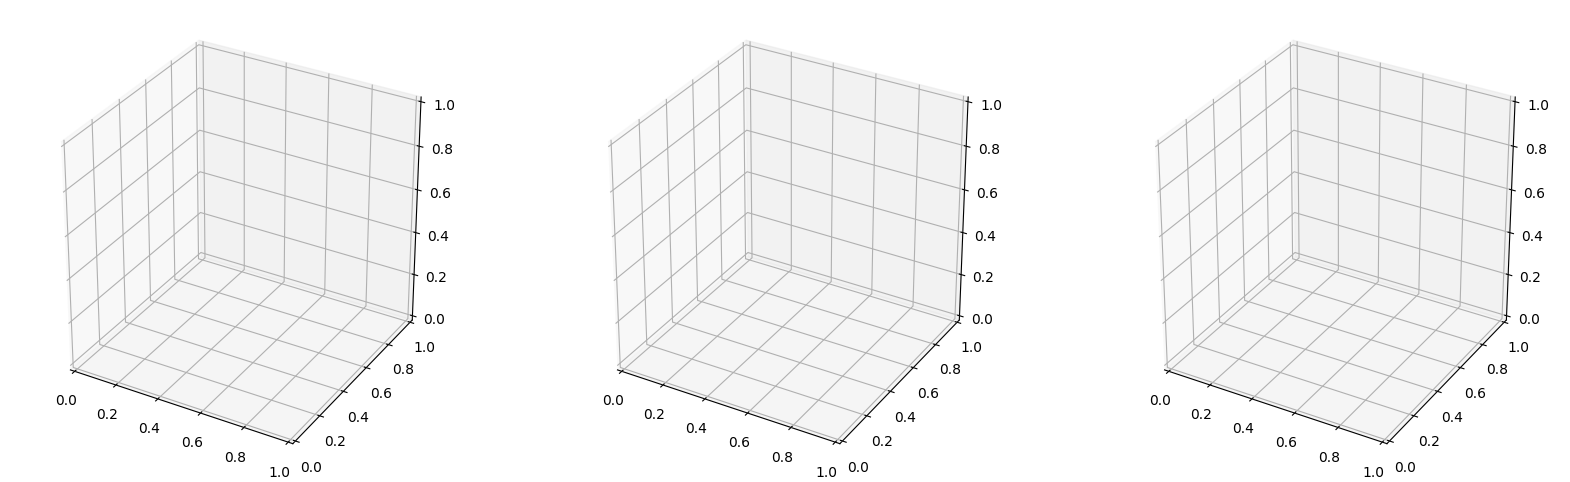

In [ ]:
plt.style.use('default')

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='b')
    ax.set_xlabel('415nm', fontsize=12)
    ax.set_ylabel('680nm', fontsize=12)
    ax.set_zlabel('PPFD', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')



ax1.view_init(elev=10, azim=120)
ax2.view_init(elev=0, azim=114)
ax3.view_init(elev=50, azim=100)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()